In [1]:
!pip install imgaug
import pandas as pd
import os
import json
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Dropout
from keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import imgaug.augmenters as iaa
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import warnings

warnings.filterwarnings("ignore")

drive.mount('/content/drive')
!unzip /content/drive/MyDrive/train2014.zip -d /content/train2014
!unzip /content/drive/MyDrive/v2_Annotations_Train_mscoco.zip -d /content/annotations
!unzip /content/drive/MyDrive/v2_Questions_Train_mscoco.zip -d /content/questions
!unzip /content/drive/MyDrive/glove.zip -d /content


Streaming output truncated to the last 5000 lines.
 extracting: /content/train2014/train2014/COCO_train2014_000000200024.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000435713.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000249993.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000424160.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000142761.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000532668.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000564904.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000346384.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000560934.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000122356.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000193042.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000072702.jpg  
 extracting: /content/train2014/train

In [2]:
# Paths fto the questions and annotations
questions_path = '/content/questions/v2_OpenEnded_mscoco_train2014_questions.json'
anno_path = '/content/annotations/v2_mscoco_train2014_annotations.json'

# create dataset
COCO_dataset = pd.merge(pd.DataFrame(json.load(open(questions_path, 'r'))['questions']), pd.DataFrame(json.load(open(anno_path, 'r'))['annotations']), on=["image_id", "question_id"])
COCO_dataset = COCO_dataset[['image_id', 'question_id', 'question', 'question_type', 'multiple_choice_answer', 'answers', 'answer_type']]
COCO_dataset['image_id'] = ['%s/COCO_%s_%012d.jpg' % ('train2014', 'train2014', img) for img in COCO_dataset['image_id']]
COCO_dataset['answers'] = [[dic['answer'] for dic in COCO_dataset['answers'][i]] for i in range(len(COCO_dataset))]

In [3]:
def decontractions(phrase):
    """
    The list of contractions are directly taken from this stackoverflow post.
    The code was changed to be more readable
    https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
    :param phrase: textual input
    :return: textual input with decontractions all removed
    """
    contractions = {
        r"won't": "will not",
        r"can't": "can not",
        r"he's": "he is",
        r"she's": "she is",
        r"it's": "it is",
        r"n't": " not",
        r"'re": " are",
        r"'d": " would",
        r"'ll": " will",
        r"'ve": " have",
        r"'m": " am",
        r"won’t": "will not",
        r"can’t": "can not",
        r"he\’s": "he is",
        r"she\’s": "she is",
        r"it\’s": "it is",
        r"n\’t": " not",
        r"\’re": " are",
        r"\’d": " would",
        r"\’ll": " will",
        r"\’ve": " have",
        r"\’m": " am",
    }

    for pattern, replacement in contractions.items():
        phrase = re.sub(pattern, replacement, phrase)
    return phrase


# proprocessing function
def text_preprocess(text):
    text = decontractions(text.lower())
    return re.sub('[-,:]|(?!<=\d)(\.)(?!\d)|[^A-Za-z0-9. ]+| +', lambda processed: ' ' if processed.group() != '.' else '', text)

In [4]:
# preprocess the data
COCO_dataset["question_preprocessed"] = COCO_dataset["question"].map(lambda x: text_preprocess(x))
COCO_dataset["answer_preprocessed"] = COCO_dataset["multiple_choice_answer"].map(lambda x: text_preprocess(x))
COCO_dataset = COCO_dataset[['image_id', 'question_id', 'question_preprocessed', 'question_type', 'answer_preprocessed', 'answers', 'answer_type']]

"""
following function provided by https://github.com/niralidedaniya/Visual-Question-Answering/blob/main/Model.ipynb
"""
answer_preprocessed = list(COCO_dataset['answer_preprocessed'])
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1

In [5]:
# Create the encoder on top 1000 answers
answers_count = pd.DataFrame(list(count.items()), columns=['Answer', 'Count'])
total_answers = len(COCO_dataset['answer_preprocessed'])
answers_count['Percentage'] = answers_count['Count'] / total_answers * 100
top_answers = answers_count.nlargest(1000, 'Count')['Answer'].tolist()
labelencoder = LabelEncoder()
labelencoder.fit(top_answers)

# Create the prepcoessed dataset with encoder
COCO_dataset_processed = COCO_dataset[COCO_dataset['answer_preprocessed'].isin(top_answers)]
COCO_dataset_processed['class_label'] = labelencoder.transform(list(COCO_dataset_processed['answer_preprocessed']))
COCO_dataset_processed = COCO_dataset_processed.drop(['question_id', 'question_type', 'answer_type'], axis=1)

In [6]:
# Test train split
X = COCO_dataset_processed[['image_id', 'question_preprocessed', 'answers']]
y = COCO_dataset_processed['class_label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train, random_state=42)
Y_train = to_categorical(y_train, 1000)
Y_val = to_categorical(y_val, 1000)
Y_test = to_categorical(y_test, 1000)

# Fit the tokenizer
t = Tokenizer(filters='')
t.fit_on_texts(list(X_train['question_preprocessed']))
vocab_size = len(t.word_index) + 1

In [7]:
# Create the glove embeddings
glove_file = '/content/glove.6B/glove.6B.300d.txt'
glove_vector = {}
with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = [float(val) for val in values[1:]]
        glove_vector[word] = vector

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = glove_vector.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:

"""
For the following data generator, the generators are directly used from this medium article
https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
The data augmentations for the validation set and coco dataset are given by this repository
https://github.com/niralidedaniya/Visual-Question-Answering/blob/main/Model.ipynb
Custom tensors and sanity checks were inserted to their prebuilt data generators
"""
train2014_content_path = "/content/train2014/"
aug1 = iaa.Fliplr(0.5)
aug2 = iaa.AddToBrightness((-30, -20))
aug3 = iaa.LinearContrast((0.6, 0.75))
class CustomDataGen_aug(tf.keras.utils.Sequence):

    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):

        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

    def __get_input1(self, que):

        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):

        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Image at path {path} could not be loaded.")
        if not isinstance(img, np.ndarray):
            raise TypeError(f"Expected img to be a numpy array, got {type(img)}")

        a = np.random.uniform()
        if a < 0.25:
            img = aug1.augment_image(img)
        elif a < 0.5:
            img = aug2.augment_image(img)
        elif a < 0.75:
            img = aug3.augment_image(img)
        else:
            img = img
        img = cv2.resize(img, (224, 224))

        img = np.array(img) / 255.0

        return img

    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)

    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
        X1_batch = np.asarray([self.__get_input2(train2014_content_path + path) for path in batch_x1])
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])

        X0_batch = tf.convert_to_tensor(X0_batch, dtype=tf.float32)
        X1_batch = tf.convert_to_tensor(X1_batch, dtype=tf.float32)
        y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)

        return tuple([X0_batch, X1_batch]), y_batch

    def __len__(self):
        return len(self.indexes) // self.batch_size


class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):

        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

    def __get_input1(self, que):

        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):

        img = cv2.imread(path)
        if img is None:
            raise Exception(f"Failed to load image at path: {path}")
        if not isinstance(img, np.ndarray):
            raise TypeError(f"Expected img to be a numpy array, got {type(img)}")
        img = cv2.resize(img, (224, 224))

        img = np.array(img) / 255.0

        return img

    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)

    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
        X1_batch = np.asarray([self.__get_input2(train2014_content_path + path) for path in batch_x1])
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])

        X0_batch = tf.convert_to_tensor(X0_batch, dtype=tf.float32)
        X1_batch = tf.convert_to_tensor(X1_batch, dtype=tf.float32)
        y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)

        return tuple([X0_batch, X1_batch]), y_batch

    def __len__(self):
        return len(self.indexes) // self.batch_size



In [10]:
# Create the data generators
training_data_generator = CustomDataGen_aug(list(X_train['question_preprocessed']), list(X_train['image_id']), list(y_train),batch_size=128)
validation_data_generator = CustomDataGen(list(X_val['question_preprocessed']), list(X_val['image_id']), list(y_val), batch_size=128)

# Initializing empty lists to store image vectors, question vectors, and labels
test_image = []
test_que = []
Y_test = []

# Looping over each item in the test dataset
for i in tqdm(range(len(X_test))):
    # Extracting the preprocessed question for the current index
    question = list(X_test['question_preprocessed'])[i]
    # Extracting the image ID for the current index
    img_id = list(X_test['image_id'])[i]
    # Extracting the label for the current index
    label = list(y_test)[i]
    # Constructing the path to the image file
    image_path = os.path.join("/content/train2014", img_id)
    # Reading the image from the file
    image = cv2.imread(image_path)
    # Resizing the image to 224x224 pixels
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
    # Converting the image from BGR to RGB color space and normalizing it
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) / 255.0
    # Converting the image to a float32 numpy array
    image_vec = rgb_image.astype(np.float32)
    # Initializing a tokenizer for processing the question
    tokenizer = Tokenizer()
    # Tokenizing the question
    question_seq = tokenizer.texts_to_sequences([question])
    # Padding the tokenized question to a fixed length of 22
    padded_question = pad_sequences(question_seq, maxlen=22, padding='post')
    # Converting the padded question to a float32 numpy array
    question_vec = np.asarray(padded_question[0]).astype(np.float32)
    # Encoding the label as a one-hot vector with a size of 1000
    encoded_label = tf.one_hot(tf.cast(int(label), tf.uint8), 1000)
    # Converting the encoded label to a float32 numpy array
    label_vec = np.asarray(encoded_label).astype(np.float32)
    # Appending the image, question, and label vectors to their respective lists
    test_image.append(image_vec)
    test_que.append(question_vec)
    Y_test.append(label_vec)

100%|██████████| 34939/34939 [10:56<00:00, 53.23it/s]


In [11]:
# Confirm type of all values
test_image = np.asarray(test_image).astype(np.float32)
test_que = np.asarray(test_que).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

# Get pretrained model
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=True, weights="imagenet",pooling='avg')
for layer in pre_trained_model.layers:
    layer.trainable = False
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            setattr(layer, attr, tf.keras.regularizers.l2(0.01))

574710816/574710816 [==============================] - 25s 0us/step


In [12]:
# Create LSTM model
img_processing_layer = Dense(units=1024, activation='relu', kernel_initializer='he_normal')(pre_trained_model.get_layer('fc2').output)
img_dropout = Dropout(rate=0.2)(img_processing_layer)
question_input = Input(shape=(22,))
question_embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=22, trainable=False)(question_input)
lstm_layer1 = LSTM(64, return_sequences=True)(question_embedding)
dropout_layer1 = Dropout(rate=0.5)(lstm_layer1)
lstm_layer2 = LSTM(64)(dropout_layer1)
dropout_layer2 = Dropout(rate=0.5)(lstm_layer2)
question_dense = Dense(units=1024, activation='relu', kernel_initializer='he_normal')(dropout_layer2)
combined_features = tf.math.multiply(question_dense, img_dropout)
final_output = Dense(units=1000, activation='softmax', kernel_initializer="glorot_uniform")(combined_features)
model_vgg19_lstm = Model(inputs=[question_input, pre_trained_model.input], outputs=final_output)

In [13]:
# Add optimizer and compile
model_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_vgg19_lstm.compile(optimizer=model_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train model
history_lstm_vgg19 = model_vgg19_lstm.fit(training_data_generator, batch_size=4, epochs=1, verbose=1, validation_data=validation_data_generator)

 263/2456 [==>...........................] - ETA: 43:56 - loss: 4.4996 - accuracy: 0.2162

KeyboardInterrupt: ignored

In [15]:
# inference function s
def get_input1(que):
    t = Tokenizer(filters='')
    que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
    return que_arr


def get_input2(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image at path {path} could not be loaded.")

    if not isinstance(img, np.ndarray):
        raise TypeError(f"Expected img to be a numpy array, got {type(img)}")

    a = np.random.uniform()
    if a < 0.25:
        img = aug1.augment_image(img)
    elif a < 0.5:
        img = aug2.augment_image(img)
    elif a < 0.75:
        img = aug3.augment_image(img)
    else:
        img = img
    img = cv2.resize(img, (224, 224))

    img = np.array(img) / 255.0

    return img

1/1 [==============================] - 0s 24ms/step


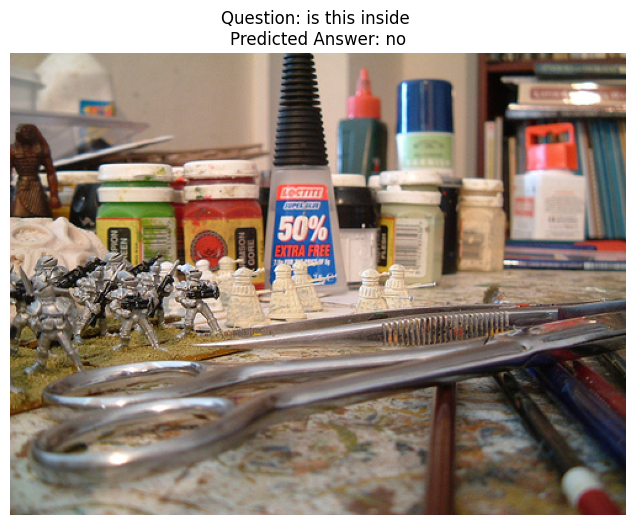

In [17]:
# Input image information
single_image_path = '/content/train2014/train2014/COCO_train2014_000000142761.jpg'
single_question = "is this inside"
actual_answer = "yes"

img_input = get_input2(single_image_path)
question_input = get_input1(single_question)

predicted = model_vgg19_lstm.predict([np.expand_dims(question_input, axis=0), np.expand_dims(img_input, axis=0)])
predicted_answer = labelencoder.inverse_transform([np.argmax(predicted)])[0]

plt.figure(figsize=(8, 6))
img = plt.imread(single_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Question: {single_question} \nPredicted Answer: {predicted_answer}')
plt.show()